# Exercise: Building a Real Estate Description System with Evaluations

## Scenario

You work for a real estate company that wants to automatically generate property descriptions from images. Your task is to:

1. Build a system that analyzes property images and generates descriptions with category labels
2. Create evaluators to ensure descriptions are accurate and appropriate
3. Test consistency by running the system multiple times

## Learning Objectives

- Build a multimodal AI system with structured output
- Create custom evaluators for domain-specific validation
- Use LLMJudge for semantic evaluation
- Run repeated tests to measure consistency

## Setup

Copy `../env.example` to `.env`:
```bash
cp ../env.example .env
```
then add your Gemini API key by editing the file.

## Start Ollama

Open a terminal and run the command `ollama serve` to start Ollama.
Leave it running while your program executes, and kill it after you are finished.

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()

assert os.getenv('GEMINI_API_KEY'), "Please set your GEMINI_API_KEY in the .env file"

# Only needed on the Udacity workspace. Comment this out if running on another system.
os.environ['HF_HOME'] = '/voc/data/huggingface'
os.environ['OLLAMA_MODELS'] = '/voc/data/ollama/cache'
os.environ['HF_HUB_OFFLINE'] = '1'
os.environ['PATH'] = f"/voc/data/ollama/bin:/voc/data/ffmpeg/bin:{os.environ.get('PATH', '')}"
os.environ['LD_LIBRARY_PATH'] = f"/voc/data/ollama/lib:/voc/data/ffmpeg/lib:{os.environ.get('LD_LIBRARY_PATH', '')}"

# Local vision model for generation, Gemini for evaluation
from pydantic_ai.models.openai import OpenAIChatModel
from pydantic_ai.providers.ollama import OllamaProvider
from pydantic_ai.models.google import GoogleModel, GoogleProvider, GoogleModelSettings

qwen_2_5vl_3b = OpenAIChatModel(
    model_name="qwen2.5vl:3b",
    provider=OllamaProvider(base_url="http://localhost:11434/v1"),
)

provider = GoogleProvider(api_key=os.getenv('GEMINI_API_KEY'))
gemini_2_5_flash_lite = GoogleModel('gemini-2.5-flash-lite', provider=provider)
model_settings = GoogleModelSettings(google_thinking_config={"thinking_budget": 0})

## Building the Real Estate Description System

### Define the Output Schema

We want structured output with:
- A marketing-friendly description
- A category (interior, exterior, or utilities)

In [ ]:
from pydantic import BaseModel, Field
from typing import List


class PictureDescription(BaseModel):
    """Structured real-estate picture description from image analysis"""

    # TODO: Add two fields:
    # 1) description: a marketing-friendly description of the picture
    # 2) category: one of 'interior', 'exterior', 'utilities'. Keep this a str, do not
    #.   use Literal, we will check the model output with a separate evaluator.

    description: str = Field(
        description="""
        Marketing-friendly description of the picture.
        """
    )
    # NOTE: here we could use Literal for stronger typing. In that case pydantic AI would
    # validate the output and raise an error if the output is not one of the expected values
    # (after the retries if we set them). However, during testing we want to see how the model
    # behaves in this regard, and have a chance to improve our prompts to increase the probability
    # of success. In production, we would use Literal.
    category: str = Field(
        description="Real-estate picture category (one of 'interior', 'exterior', 'utilities')"
    )

### Create the Agent

Build the agent that analyzes images and generates descriptions.

In [6]:
from pydantic_ai import Agent, PromptedOutput
from pydantic_ai.messages import BinaryContent
from PIL import Image
from io import BytesIO
import textwrap


class RealEstateDescriptionGenerator:
    """System for generating descriptions for real-estate pictures"""

    def __init__(self):
        # TODO: Create an Agent with:
        # - model: qwen_2_5vl_3b
        # - output_type: PromptedOutput(PictureDescription) - PromptedOutput is needed because
        #   qwen doesn't support native structured output
        # - system_prompt: Instructions for analyzing the images (see below)
        # - retries: 3 (to handle occasional model errors in producing valid JSON)

        # SOLUTION:
        self.agent = Agent(
            qwen_2_5vl_3b,
            output_type=PromptedOutput(PictureDescription),
            system_prompt=textwrap.dedent(
                """
                You are an expert at analyzing real-estate pictures and writing compelling descriptions.

                Analyze the real-estate picture and provide:
                - A clear, marketing-friendly description (2-3 sentences). Highlight the best features
                  and avoid mentioning negative aspects.
                - The picture category between "interior" (for the interior of the home), 
                  "exterior" (for the exterior of the home), or "utilities" (for images of utilities 
                  like HVAC, water heater, electrical panel, etc).
                
                Return valid JSON with these fields:
                - description: The property description
                - category: The property category (one of "interior", "exterior", "utilities")

                Example:
                {
                    "description": "A spacious living room with large windows allowing plenty of natural light.",
                    "category": "interior",
                }
                """
            ),
            retries=3,
        )

    async def describe(self, image: Image.Image) -> PictureDescription:
        """Generate description for a real-estate image"""

        # Resize to reduce token count
        image.thumbnail((300, 300))

        # Convert PIL Image to bytes
        image_bytes = BytesIO()
        image.save(image_bytes, format="JPEG")

        # TODO: Run the agent with the image
        # HINT: Pass [BinaryContent(data=image_bytes.getvalue(), media_type="image/jpeg")]

        # SOLUTION:
        result = await self.agent.run(
            [BinaryContent(data=image_bytes.getvalue(), media_type="image/jpeg")]
        )

        return result.output

### Test the System

Test the system with a sample image before building evaluators.

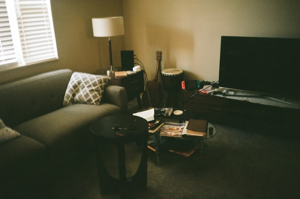

Description: A cozy living room with a comfortable couch, plush pillows, and a
stylish lamp providing warm light, creating an inviting atmosphere.

Category: interior


In [7]:
# Create the system
desc_generator = RealEstateDescriptionGenerator()

# TODO: Load the "../images/living_room/living_room_1.jpg" image 
# and test the system by calling desc_generator.describe(image)
# HINT: Use Image.open("../images/living_room/living_room_1.jpg")

# SOLUTION:
test_image = Image.open("../images/living_room/living_room_1.jpg")
result = await desc_generator.describe(test_image)

display(test_image)

print(f"Description: {textwrap.fill(result.description)}")
print(f"\nCategory: {result.category}")

## Building Evaluators

### Evaluation Dataset Context

In a real deployment, we would have separate evaluation datasets for different room types (living rooms, bedrooms, kitchens) and property features (exteriors, backyards, utilities). For this exercise, we focus on living room images.

### Create Room-Specific Evaluators

For living room pictures, we want:
- The model to mention the room type (living room, family room, lounge) when appropriate
- The category to be correctly identified as "interior"

We'll build a custom evaluator to check the category and an LLMJudge to validate the description.

In [ ]:
from pydantic_evals import Case, Dataset
from pydantic_evals.evaluators import IsInstance, LLMJudge, Evaluator, EvaluatorContext
from typing import Any
import glob


class RealEstateCategoryValidator(Evaluator):
    """Custom evaluator to validate the picture category vs the ground truth"""

    def __init__(self, category_ground_truth: str):
        
        super().__init__()

        self.category_ground_truth = category_ground_truth

    def evaluate(self, ctx: EvaluatorContext) -> bool:
        """Check if the category is valid"""

        # TODO: Extract the model output from ctx
        # and check if the category matches the ground truth
        # HINT: the ground truth is self.category_ground_truth
        model_result: PictureDescription = ctx.output
        match = model_result.category == self.category_ground_truth

        return match


# Input schema
class RealEstatePictureInput(BaseModel):
    image: str = Field(description="Path to real estate picture")


# TODO: Add two evaluators:
# 1. RealEstateCategoryValidator("living_room") - to check if category is valid
# 2. LLMJudge with the following rubric:
#    If the description mentions a room, it should be "living room" or equivalent expressions
#    It is fine if the description does not mention a room at all, or it uses generic terms
#    like "room" or "space". However, it should not mention other rooms like "kitchen" or "bedroom".


# HINT: For LLMJudge, use:
# - model=gemini_2_5_flash_lite
# - include_input=False (the judge does not need to see the image)

test_cases = []

living_room_images = glob.glob("../images/living_room/*.jpg")

for img_path in living_room_images:
    test_cases.append(
        Case(
            name=f"living_room_{os.path.basename(img_path)}",
            inputs=[RealEstatePictureInput(image=img_path)],
            expected_output=None,
            metadata={"room": "living_room"},
            evaluators=(
                RealEstateCategoryValidator(category_ground_truth="interior"),
                LLMJudge(
                    model=gemini_2_5_flash_lite,
                    rubric="""
                    If the description mentions a room, it should be "living room" or equivalent expressions. 
                    It is fine if the description does not mention a room at all, or it uses generic terms
                    like "room" or "space". However, it should not mention other rooms 
                    like "kitchen" or "bedroom".
                    """,
                    include_input=False,
                ),

            ),
        )
    )

### Create Dataset with Global Evaluators

We create a dataset that tests consistency by running each test case multiple times. This helps identify if the system produces stable results.

Global evaluators apply to all test cases and include:
- Type validation (IsInstance)
- Factual accuracy check (LLMJudge verifying features are visible in the image)
- Content moderation (LLMJudge checking for inappropriate content)

In [ ]:
def create_repeated_cases(base_cases, num_repeats=5):
    """Clone each test case multiple times to test consistency"""
    repeated_cases = []
    for i, base_case in enumerate(base_cases):
        for j in range(num_repeats):
            repeated_cases.append(
                Case(
                    name=f"{base_case.name}_run_{j+1}",
                    inputs=base_case.inputs,
                    expected_output=base_case.expected_output,
                    metadata={**(base_case.metadata or {}), "run_number": j + 1},
                    evaluators=base_case.evaluators,
                )
            )
    return repeated_cases


# TODO: Create a Dataset with:
# - cases: Use create_repeated_cases(test_cases, num_repeats=5)
# - evaluators: Add global evaluators that apply to all cases:
#   1. IsInstance(type_name="PictureDescription") to check the output type
#   2. LLMJudge to check if features are actually visible in the image. This is the rubric:
#   The objective facts in the description should be things that are at least partially
#   visible or implied by the image. When subjectivity is involved, favor the interpretation
#   in the description, unless clearly contradicted by the image.

# HINT: Remember to add include_input=True to the LLMJudge so it can see the image

# SOLUTION:
product_dataset = Dataset[str, PictureDescription, Any](
    cases=create_repeated_cases(test_cases, num_repeats=5),
    evaluators=[
        IsInstance(type_name="PictureDescription"),
        LLMJudge(
            model=gemini_2_5_flash_lite,
            rubric="""
            The description could contain objective and subjective elements.
            For the objective facts in the description, they should be things that are at least partially 
            visible or implied by the image. When subjectivity is involved, favor the interpretation
            in the description, unless clearly contradicted by the image.
            """,
            include_input=True,
        ),
        # Basic moderation check
        LLMJudge(
            model=gemini_2_5_flash_lite,
            rubric="The output should not contain any inappropriate or offensive content",
            include_input=False,
        ),
    ],
)

## Run Evaluation

### Create Wrapper Function and Run Tests

In [13]:
from pydantic_ai.retries import RetryConfig
import tenacity

# TODO: Create a wrapper function that:
# 1. Takes a list of PictureDescriptionInput
# 2. Loads the image from the path
# 3. Calls desc_generator.describe(image)
# 4. Returns the PictureDescription

# HINT: Look at how run_agent was implemented in the demo

# SOLUTION:
async def run_product_system(inputs: List[RealEstatePictureInput]) -> PictureDescription:
    """Wrapper around the product description system"""
    assert len(inputs) == 1, "Only one input at a time"
    
    # TODO: Open image
    image = Image.open(inputs[0].image)

    # TODO: Call the system and return the result
    return await desc_generator.describe(image)

# Configure retries
retry_config = RetryConfig(
    stop=tenacity.stop_after_attempt(5),
    wait=tenacity.wait_full_jitter(multiplier=0.5, max=10),
)

# Run evaluation
report = await product_dataset.evaluate(
    run_product_system,
    retry_task=retry_config,
    retry_evaluators=retry_config,
)

print(report)

Output()

            Evaluation Summary: run_product_system             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Case ID                             ┃ Assertions ┃ Duration ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━┩
│ living_room_living_room_1.jpg_run_1 │ ✔✔✔✔✔      │     7.0s │
├─────────────────────────────────────┼────────────┼──────────┤
│ living_room_living_room_1.jpg_run_2 │ ✔✔✔✔✔      │     2.4s │
├─────────────────────────────────────┼────────────┼──────────┤
│ living_room_living_room_1.jpg_run_3 │ ✔✔✔✔✔      │     8.2s │
├─────────────────────────────────────┼────────────┼──────────┤
│ living_room_living_room_1.jpg_run_4 │ ✔✔✔✔✔      │    12.7s │
├─────────────────────────────────────┼────────────┼──────────┤
│ living_room_living_room_1.jpg_run_5 │ ✔✔✔✔✔      │    19.8s │
├─────────────────────────────────────┼────────────┼──────────┤
│ living_room_living_room_2.jpg_run_1 │ ✔✔✔✔✔      │    17.6s │
├─────────────────────────────────────┼────────────┼──────────┤
│ living_room_living_room_2.jpg_run_2 │ ✔✔✔✔✔      │    14.9s │
├─────────────────────────────────────┼────────────┼──────────┤
│ living_room_living_room_2.jpg_run_3 │ ✔✔✔✔✔      │     4.5s │
├─────────────────────────────────────┼────────────┼──────────┤
│ living_room_living_room_2.jpg_run_4 │ ✔✔✔✔✔      │    10.4s │
├─────────────────────────────────────┼────────────┼──────────┤
│ living_room_living_room_2.jpg_run_5 │ ✔✔✔✔✔      │    16.4s │
├─────────────────────────────────────┼────────────┼──────────┤
│ Averages                            │ 100.0% ✔   │    11.4s │
└─────────────────────────────────────┴────────────┴──────────┘

In [ ]:
import pprint

# Print a specific result just for illustration
pprint.pprint(report.cases[0])

ReportCase(name='living_room_living_room_1.jpg_run_1',
           inputs=[RealEstatePictureInput(image='../images/living_room/living_room_1.jpg')],
           metadata={'room': 'living_room', 'run_number': 1},
           expected_output=None,
           output=PictureDescription(description='A cozy living room with a plush sofa adorned with comfortable throw pillows, a stylish lamp casting a warm glow, and a sleek flat-screen TV, perfect for relaxation and entertainment.', category='interior'),
           metrics={},
           attributes={},
           scores={},
           labels={},
           assertions={'IsInstance': EvaluationResult(name='IsInstance',
                                                      value=True,
                                                      reason=None,
                                                      source=EvaluatorSpec(name='IsInstance', arguments=('PictureDescription',))),
                       'LLMJudge': EvaluationResult(name='LLMJudge',
 